In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [3]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system','9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "../data_msg_type/"
trainX_path = dataset_path + "semantic_train_x.txt"
trainY_path = dataset_path + "semantic_train_y.txt"
testX_path = dataset_path + "semantic_test_x.txt"
testY_path = dataset_path + "semantic_test_y.txt"


train_x = load_X(trainX_path)
train_y = load_y(trainY_path)
test_x = load_X(testX_path)
test_y = load_y(testY_path)

train_x = train_x.reshape(len(train_x), 10, 14, 1)
test_x = test_x.reshape(len(test_x), 10, 14, 1)

'''
# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
'''

print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Dataset separated.

((80000, 10, 14, 1), (80000, 14), (20000, 10, 14, 1), (20000, 14))


# define parameters

In [5]:
learning_rate = 0.0001
training_iters = 16000000
batch_size = 1000
display_step = 20000

# Network Parameters
input_height = 10
input_width = 14
num_channels = 1
n_classes = 14
dropout = 0.5 # Dropout, probability to keep units

# network config

In [6]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 10, 14, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)
    
    # Convolution Layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'])
    conv5 = conv2d(conv4, weights['wc5'], biases['bc5'])
    # Max Pooling (down-sampling)
    conv5 = maxpool2d(conv5, k=2)
    print(conv3.shape)
    print(conv4.shape)
    print(conv5.shape)

    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv5, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    print(fc1.shape)
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    print(fc2.shape)

    # Output, class prediction
    fc3 = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    print(fc3.shape)
    return fc3

# Store layers weight & bias
weights = {
    # 3x4 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([3, 4, 1, 32])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([3, 4, 32, 64])),
    # 3x4 conv, 64 inputs, 64 outputs
    'wc3': tf.Variable(tf.random_normal([3, 4, 64, 64])),
    # 3x4 conv, 64 inputs, 32 outputs
    'wc4': tf.Variable(tf.random_normal([3, 4, 64, 32])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc5': tf.Variable(tf.random_normal([3, 4, 32, 64])),
    # fully connected, 2*2*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([2*2*64, 1024])),
    # fully connected, 1024 inputs, 512 outputs
    'wd2': tf.Variable(tf.random_normal([1024, 512])),
    # 512 inputs, 14outputs (class prediction)
    'out': tf.Variable(tf.random_normal([512, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bc3': tf.Variable(tf.random_normal([64])),
    'bc4': tf.Variable(tf.random_normal([32])),
    'bc5': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'bd2': tf.Variable(tf.random_normal([512])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# build model

In [7]:
x = tf.placeholder(tf.float32, [None,input_height,input_width,num_channels])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

(?, 5, 7, 32)
(?, 3, 4, 64)
(?, 3, 4, 64)
(?, 3, 4, 32)
(?, 2, 2, 64)
(?, 1024)
(?, 512)
(?, 14)


# train and test

In [8]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s


test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


init = tf.global_variables_initializer()
with tf.Session(config=sess_config) as sess:
    sess.run(init)
    
    step = 1
    # Keep training until reach max iterations
    while step * batch_size <= training_iters:
        batch_xs = extract_batch_size(train_x, step, batch_size)
        batch_ys = extract_batch_size(train_y, step, batch_size)

        # Fit training using batch data
        _, loss, acc = sess.run([optimizer, cost, accuracy],
                       feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})

        train_losses.append(loss)
        train_accuracies.append(acc)  
        
        
        batch_xt = extract_batch_size(test_x, step, batch_size)
        batch_yt = extract_batch_size(test_y, step, batch_size)
    
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_predict, test_loss, test_acc = sess.run([pred, cost, accuracy], 
                                            feed_dict={x: batch_xt, y: batch_yt, keep_prob: 1.})
        
        test_predictions.append(np.argmax(test_predict, axis=1))
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_step == 0) or (step == 1) \
            or (step * batch_size > training_iters):

            print("Training epochs #" + str(step*batch_size) + \
                  ": Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))
        
            print("Performance on test set: " + "Training epochs #" + str(step*batch_size) +\
                  ", Batch Loss = {}".format(test_loss) + ", Accuracy = {}".format(test_acc))
        step += 1

    print("Optimization Finished!")

Training epochs #1000: Batch Loss = 1160201088.000000, Accuracy = 0.0270000007004
Performance on test set: Training epochs #1000, Batch Loss = 325935136.0, Accuracy = 0.131999999285
Training epochs #20000: Batch Loss = 758705792.000000, Accuracy = 0.0519999936223
Performance on test set: Training epochs #20000, Batch Loss = 112103512.0, Accuracy = 0.0
Training epochs #40000: Batch Loss = 263471520.000000, Accuracy = 0.226999983191
Performance on test set: Training epochs #40000, Batch Loss = 18925092.0, Accuracy = 0.805000066757
Training epochs #60000: Batch Loss = 188875760.000000, Accuracy = 0.379999995232
Performance on test set: Training epochs #60000, Batch Loss = 33056902.0, Accuracy = 0.805000066757
Training epochs #80000: Batch Loss = 140120656.000000, Accuracy = 0.495000004768
Performance on test set: Training epochs #80000, Batch Loss = 45507476.0, Accuracy = 0.804999947548
Training epochs #100000: Batch Loss = 600350592.000000, Accuracy = 0.0379999987781
Performance on test 

Training epochs #920000: Batch Loss = 12499410.000000, Accuracy = 0.68900001049
Performance on test set: Training epochs #920000, Batch Loss = 2026456.0, Accuracy = 0.949000000954
Training epochs #940000: Batch Loss = 10270564.000000, Accuracy = 0.773000001907
Performance on test set: Training epochs #940000, Batch Loss = 2521872.75, Accuracy = 0.942999958992
Training epochs #960000: Batch Loss = 7788431.000000, Accuracy = 0.818000018597
Performance on test set: Training epochs #960000, Batch Loss = 2917320.25, Accuracy = 0.942999958992
Training epochs #980000: Batch Loss = 70040152.000000, Accuracy = 0.211999982595
Performance on test set: Training epochs #980000, Batch Loss = 1888984.25, Accuracy = 0.949000060558
Training epochs #1000000: Batch Loss = 10867502.000000, Accuracy = 0.740000069141
Performance on test set: Training epochs #1000000, Batch Loss = 1754819.25, Accuracy = 0.949000060558
Training epochs #1020000: Batch Loss = 8528805.000000, Accuracy = 0.783999979496
Performanc

Training epochs #1820000: Batch Loss = 3338838.500000, Accuracy = 0.842999994755
Performance on test set: Training epochs #1820000, Batch Loss = 674973.0625, Accuracy = 0.961000025272
Training epochs #1840000: Batch Loss = 2215794.750000, Accuracy = 0.89200001955
Performance on test set: Training epochs #1840000, Batch Loss = 730351.0, Accuracy = 0.961000025272
Training epochs #1860000: Batch Loss = 26797206.000000, Accuracy = 0.316999971867
Performance on test set: Training epochs #1860000, Batch Loss = 436023.875, Accuracy = 0.961000025272
Training epochs #1880000: Batch Loss = 2784522.250000, Accuracy = 0.851999998093
Performance on test set: Training epochs #1880000, Batch Loss = 484939.9375, Accuracy = 0.961000084877
Training epochs #1900000: Batch Loss = 2504291.500000, Accuracy = 0.885000050068
Performance on test set: Training epochs #1900000, Batch Loss = 631671.875, Accuracy = 0.961000025272
Training epochs #1920000: Batch Loss = 2251667.000000, Accuracy = 0.900999963284
Perf

Training epochs #2720000: Batch Loss = 872583.250000, Accuracy = 0.935000061989
Performance on test set: Training epochs #2720000, Batch Loss = 218827.09375, Accuracy = 0.968000054359
Training epochs #2740000: Batch Loss = 10237656.000000, Accuracy = 0.446999996901
Performance on test set: Training epochs #2740000, Batch Loss = 123375.140625, Accuracy = 0.990000128746
Training epochs #2760000: Batch Loss = 1130532.625000, Accuracy = 0.893999993801
Performance on test set: Training epochs #2760000, Batch Loss = 127440.25, Accuracy = 0.990000128746
Training epochs #2780000: Batch Loss = 843742.437500, Accuracy = 0.927000045776
Performance on test set: Training epochs #2780000, Batch Loss = 182915.453125, Accuracy = 0.967999994755
Training epochs #2800000: Batch Loss = 582512.250000, Accuracy = 0.93700003624
Performance on test set: Training epochs #2800000, Batch Loss = 181783.71875, Accuracy = 0.967999994755
Training epochs #2820000: Batch Loss = 11302955.000000, Accuracy = 0.4339999854

Training epochs #3620000: Batch Loss = 4882248.500000, Accuracy = 0.578999996185
Performance on test set: Training epochs #3620000, Batch Loss = 67747.09375, Accuracy = 0.991000056267
Training epochs #3640000: Batch Loss = 410012.406250, Accuracy = 0.948000013828
Performance on test set: Training epochs #3640000, Batch Loss = 75849.3828125, Accuracy = 0.991000056267
Training epochs #3660000: Batch Loss = 513261.500000, Accuracy = 0.941000044346
Performance on test set: Training epochs #3660000, Batch Loss = 72366.796875, Accuracy = 0.991000056267
Training epochs #3680000: Batch Loss = 296464.593750, Accuracy = 0.963999986649
Performance on test set: Training epochs #3680000, Batch Loss = 71059.40625, Accuracy = 0.990000128746
Training epochs #3700000: Batch Loss = 4535318.500000, Accuracy = 0.602000057697
Performance on test set: Training epochs #3700000, Batch Loss = 63648.640625, Accuracy = 0.991000056267
Training epochs #3720000: Batch Loss = 339463.093750, Accuracy = 0.950000047684

Training epochs #4520000: Batch Loss = 177614.312500, Accuracy = 0.97000002861
Performance on test set: Training epochs #4520000, Batch Loss = 39558.9609375, Accuracy = 0.990999937057
Training epochs #4540000: Batch Loss = 114301.406250, Accuracy = 0.974000036716
Performance on test set: Training epochs #4540000, Batch Loss = 35453.75, Accuracy = 0.991000056267
Training epochs #4560000: Batch Loss = 96825.585938, Accuracy = 0.978000044823
Performance on test set: Training epochs #4560000, Batch Loss = 32909.0820312, Accuracy = 0.991000056267
Training epochs #4580000: Batch Loss = 2504040.250000, Accuracy = 0.694000005722
Performance on test set: Training epochs #4580000, Batch Loss = 36251.5546875, Accuracy = 0.991000056267
Training epochs #4600000: Batch Loss = 192075.187500, Accuracy = 0.96899998188
Performance on test set: Training epochs #4600000, Batch Loss = 35949.5507812, Accuracy = 0.991000056267
Training epochs #4620000: Batch Loss = 201504.031250, Accuracy = 0.968000054359
Pe

Training epochs #5420000: Batch Loss = 186865.359375, Accuracy = 0.970000088215
Performance on test set: Training epochs #5420000, Batch Loss = 13054.2822266, Accuracy = 0.990999996662
Training epochs #5440000: Batch Loss = 59194.226562, Accuracy = 0.984000086784
Performance on test set: Training epochs #5440000, Batch Loss = 10620.6035156, Accuracy = 0.991000056267
Training epochs #5460000: Batch Loss = 1588050.500000, Accuracy = 0.738999962807
Performance on test set: Training epochs #5460000, Batch Loss = 17047.515625, Accuracy = 0.991000056267
Training epochs #5480000: Batch Loss = 110136.734375, Accuracy = 0.975000023842
Performance on test set: Training epochs #5480000, Batch Loss = 14177.0527344, Accuracy = 0.991000056267
Training epochs #5500000: Batch Loss = 115930.390625, Accuracy = 0.971000015736
Performance on test set: Training epochs #5500000, Batch Loss = 10375.4853516, Accuracy = 0.991000056267
Training epochs #5520000: Batch Loss = 59743.976562, Accuracy = 0.9850000739

Training epochs #6320000: Batch Loss = 16003.357422, Accuracy = 0.992000043392
Performance on test set: Training epochs #6320000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #6340000: Batch Loss = 767510.625000, Accuracy = 0.800000011921
Performance on test set: Training epochs #6340000, Batch Loss = 4859.13671875, Accuracy = 0.991000056267
Training epochs #6360000: Batch Loss = 37871.066406, Accuracy = 0.981000065804
Performance on test set: Training epochs #6360000, Batch Loss = 3193.61352539, Accuracy = 0.996999979019
Training epochs #6380000: Batch Loss = 69335.718750, Accuracy = 0.978000044823
Performance on test set: Training epochs #6380000, Batch Loss = 1479.19433594, Accuracy = 0.996999979019
Training epochs #6400000: Batch Loss = 21327.417969, Accuracy = 0.993000030518
Performance on test set: Training epochs #6400000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #6420000: Batch Loss = 786897.062500, Accuracy = 0.813000023365
Performance on test s

Training epochs #7260000: Batch Loss = 47372.414062, Accuracy = 0.985000133514
Performance on test set: Training epochs #7260000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7280000: Batch Loss = 11856.304688, Accuracy = 0.991000056267
Performance on test set: Training epochs #7280000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7300000: Batch Loss = 429690.156250, Accuracy = 0.869000017643
Performance on test set: Training epochs #7300000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7320000: Batch Loss = 24676.890625, Accuracy = 0.985000014305
Performance on test set: Training epochs #7320000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7340000: Batch Loss = 32598.261719, Accuracy = 0.989000082016
Performance on test set: Training epochs #7340000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7360000: Batch Loss = 22746.328125, Accuracy = 0.996000111103
Performance on test set: Training epochs #7360000, Batc

Training epochs #8220000: Batch Loss = 14011.244141, Accuracy = 0.989000022411
Performance on test set: Training epochs #8220000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8240000: Batch Loss = 5274.051270, Accuracy = 0.995000004768
Performance on test set: Training epochs #8240000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #8260000: Batch Loss = 280619.937500, Accuracy = 0.882000088692
Performance on test set: Training epochs #8260000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8280000: Batch Loss = 32872.960938, Accuracy = 0.986000061035
Performance on test set: Training epochs #8280000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #8300000: Batch Loss = 40877.312500, Accuracy = 0.987000048161
Performance on test set: Training epochs #8300000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8320000: Batch Loss = 19461.531250, Accuracy = 0.991000115871
Performance on test set: Training epochs #8320000, Batch Loss = 0.0, Accurac

Training epochs #9180000: Batch Loss = 9292.634766, Accuracy = 0.990000009537
Performance on test set: Training epochs #9180000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9200000: Batch Loss = 1290.365356, Accuracy = 0.998000025749
Performance on test set: Training epochs #9200000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9220000: Batch Loss = 157668.718750, Accuracy = 0.920000076294
Performance on test set: Training epochs #9220000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9240000: Batch Loss = 7919.692871, Accuracy = 0.990000009537
Performance on test set: Training epochs #9240000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9260000: Batch Loss = 22399.564453, Accuracy = 0.993000030518
Performance on test set: Training epochs #9260000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9280000: Batch Loss = 4002.409424, Accuracy = 0.995000123978
Performance on test set: Training epochs #9280000, Batch Lo

Training epochs #10140000: Batch Loss = 7507.075195, Accuracy = 0.993000030518
Performance on test set: Training epochs #10140000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10160000: Batch Loss = 4094.075439, Accuracy = 0.994000077248
Performance on test set: Training epochs #10160000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #10180000: Batch Loss = 128667.343750, Accuracy = 0.923999965191
Performance on test set: Training epochs #10180000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10200000: Batch Loss = 2426.260986, Accuracy = 0.995000064373
Performance on test set: Training epochs #10200000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10220000: Batch Loss = 14114.348633, Accuracy = 0.988999962807
Performance on test set: Training epochs #10220000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #10240000: Batch Loss = 2239.176270, Accuracy = 0.997000098228
Performance on test set: Training epochs #10240000, Batch Loss = 0.0

Training epochs #11100000: Batch Loss = 8299.675781, Accuracy = 0.995000004768
Performance on test set: Training epochs #11100000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #11120000: Batch Loss = 403.104004, Accuracy = 0.998000025749
Performance on test set: Training epochs #11120000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11140000: Batch Loss = 85690.687500, Accuracy = 0.93700003624
Performance on test set: Training epochs #11140000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11160000: Batch Loss = 3085.454346, Accuracy = 0.994000077248
Performance on test set: Training epochs #11160000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11180000: Batch Loss = 9506.202148, Accuracy = 0.992999970913
Performance on test set: Training epochs #11180000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11200000: Batch Loss = 3563.386230, Accuracy = 0.995999991894
Performance on test set: Training epochs #11200000, Batch Loss

Training epochs #12060000: Batch Loss = 1946.356934, Accuracy = 0.995000004768
Performance on test set: Training epochs #12060000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12080000: Batch Loss = 6620.797852, Accuracy = 0.995000004768
Performance on test set: Training epochs #12080000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12100000: Batch Loss = 76801.226562, Accuracy = 0.939999997616
Performance on test set: Training epochs #12100000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12120000: Batch Loss = 3774.350342, Accuracy = 0.993999958038
Performance on test set: Training epochs #12120000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12140000: Batch Loss = 3866.327393, Accuracy = 0.996000051498
Performance on test set: Training epochs #12140000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12160000: Batch Loss = 197.370392, Accuracy = 0.999000072479
Performance on test set: Training epochs #12160000,

Training epochs #13020000: Batch Loss = 58.252502, Accuracy = 0.999000072479
Performance on test set: Training epochs #13020000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #13040000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #13040000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13060000: Batch Loss = 42697.867188, Accuracy = 0.952000081539
Performance on test set: Training epochs #13060000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13080000: Batch Loss = 4171.050293, Accuracy = 0.995000123978
Performance on test set: Training epochs #13080000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13100000: Batch Loss = 5301.655273, Accuracy = 0.994000017643
Performance on test set: Training epochs #13100000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13120000: Batch Loss = 476.064026, Accuracy = 0.999000072479
Performance on test set: Training epochs #13120000, Batch Loss = 0.

Training epochs #13980000: Batch Loss = 1010.602051, Accuracy = 0.999000072479
Performance on test set: Training epochs #13980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14000000: Batch Loss = 1516.188477, Accuracy = 0.996999979019
Performance on test set: Training epochs #14000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14020000: Batch Loss = 19854.658203, Accuracy = 0.972999989986
Performance on test set: Training epochs #14020000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14040000: Batch Loss = 857.885986, Accuracy = 0.996000051498
Performance on test set: Training epochs #14040000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14060000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #14060000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14080000: Batch Loss = 1087.527344, Accuracy = 0.999000072479
Performance on test set: Training epochs #14080000, Bat

Training epochs #14940000: Batch Loss = 1920.337891, Accuracy = 0.997000098228
Performance on test set: Training epochs #14940000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14960000: Batch Loss = 0.000000, Accuracy = 1.0
Performance on test set: Training epochs #14960000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #14980000: Batch Loss = 23998.291016, Accuracy = 0.975000023842
Performance on test set: Training epochs #14980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15000000: Batch Loss = 118.958008, Accuracy = 0.999000072479
Performance on test set: Training epochs #15000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15020000: Batch Loss = 922.727051, Accuracy = 0.998000025749
Performance on test set: Training epochs #15020000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15040000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #15040000, Batch Loss = 0.0, Accuracy =

Training epochs #15900000: Batch Loss = 588.841675, Accuracy = 0.998000085354
Performance on test set: Training epochs #15900000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15920000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #15920000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #15940000: Batch Loss = 18730.757812, Accuracy = 0.980000078678
Performance on test set: Training epochs #15940000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15960000: Batch Loss = 963.302124, Accuracy = 0.998000085354
Performance on test set: Training epochs #15960000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15980000: Batch Loss = 172.913513, Accuracy = 0.999000072479
Performance on test set: Training epochs #15980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #16000000: Batch Loss = 1546.383545, Accuracy = 0.999000072479
Performance on test set: Training epochs #16000000, Batch Loss = 0.

# performance visualization

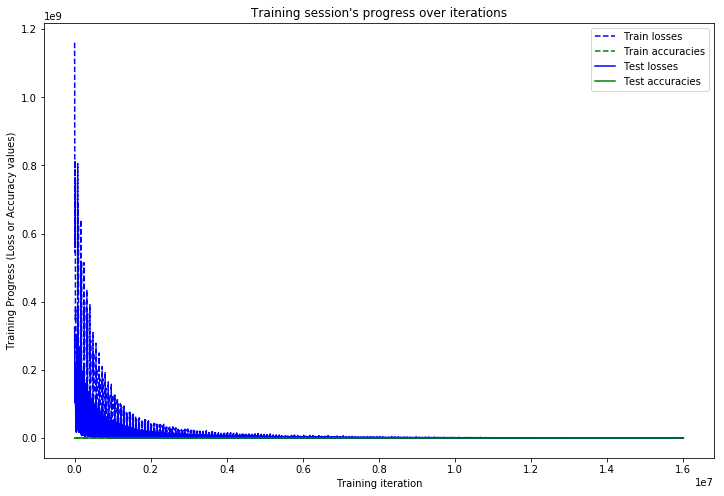

In [9]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)
width = 12
height = 8
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, 
                   (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(batch_size, 
                  len(test_losses)*batch_size, batch_size)), training_iters)
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

Best Testing Accuracy: 100.000011921%

Precision: 98.1382243908%
Recall: 98.14%
f1_score: 98.1109916425%

Confusion Matrix:
[[    5    13     0     0     0     0     0     0     0     0     0     0
      0]
 [    6   828     0     0    27    11     0     6     0     0     0    33
      0]
 [    0     0   213     0     0     0     0     0     0     0     0     0
      0]
 [    0     2     0     0     0     0     0     0     0     0     0     0
      0]
 [    0    39     0     0  2827     0     0    22     0     0     0     3
      0]
 [   11    34     0     0     0   299     0     1     0     0     0     3
      0]
 [    0     7     0     0     0     0 14486     0     0     0     0     2
      0]
 [    0    54     0     0    33    21     0   413     0     0     0    14
      0]
 [    0     0     0     0     0     0     0     0   132     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     2     0     2
      0]
 [    0     0     0     0     0     0     0   

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


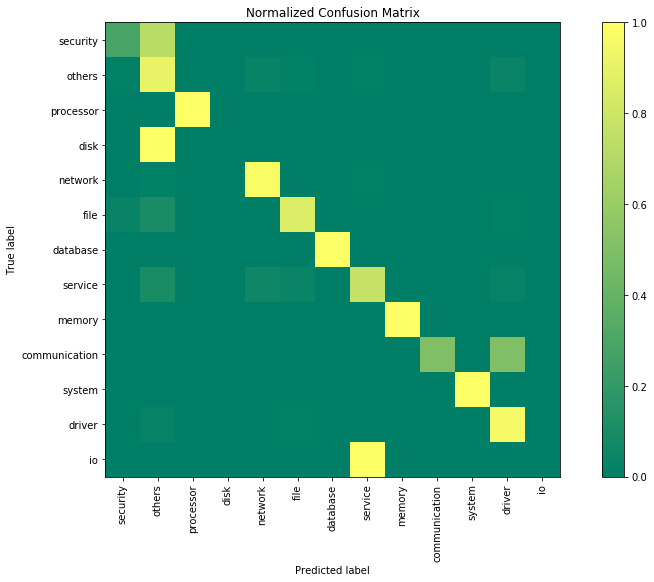

In [10]:
# Results
predictions = []
length = len(test_predictions)-20
for i in range(20):
    predictions.extend(test_predictions[length+i])

true_y = np.argmax(test_y, axis=1)

print("Best Testing Accuracy: {}%".format(100*max(test_accuracies)))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    true_y, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(true_y, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(true_y, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(true_y, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    true_y, predictions, target_names = list(labels.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)